# Introduction
We intend to produce a model based on BERT to infer capacity of predicting if a tweet can be categorized as an Alert disaster tweet or not.
Some kernels have already implemented such models :

* egortrushin/nlp-with-disaster-tweets-roberta-using-pytorch         NLP with Disaster Tweets: RoBERTa using PyTorch     Egor Trushin

* ashishsingh226/disaster-tweet-classification-using-distil-bert     Disaster Tweet Classification using Distil Bert     AshishSingh226

In a perspective to contribute to the community, we propose another implementation for BERT with fast-bert api on PyTorch.

The objective is to try achieve a high accuracy scoring by :

* implementing most appropriate pretrained model
* fine tuning hyperparameters
* fine tune optimizer

# Imports

In [ ]:
!pip install fast-bert

In [19]:
import pandas as pd
pd.options.mode.chained_assignment = None
import logging
import os
import pickle
from time import time

import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

import plotly.graph_objs as go
!pip install chart_studio
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
#plotly.offline.init_notebook_mode(connected=True)
import re
import emoji

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from collections import defaultdict

from wordcloud import WordCloud,STOPWORDS

In [ ]:
import torch
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.data_lm import BertLMDataBunch
from fast_bert.learner_lm import BertLMLearner

from fast_bert.metrics import fbeta, roc_auc, accuracy
from fast_bert.prediction import BertClassificationPredictor
from pathlib import Path
logger = logging.getLogger()
device_cuda = torch.device("cuda")

# Datasets loading

In [3]:
train_data = pd.read_csv('../input/nlp-getting-started/train.csv', sep=",")

In [4]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv', sep=",")

In [5]:
print("Total rows in train data: ", train_data.shape[0])
print("Total columns in train data: ", train_data.shape[1])
print("-"*30)
print("Total rows in test data: ", test_data.shape[0])
print("Total columns in test data: ", test_data.shape[1])

Total rows in train data:  7613
Total columns in train data:  5
------------------------------
Total rows in test data:  3263
Total columns in test data:  4


In [6]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [ ]:
test_data.describe()

In [ ]:
train_data.head()

# Data Exploration & Cleaning
I found a very interesting kernel for DEA which I get inspired from : 
https://www.kaggle.com/mohitnirgulkar/disaster-tweets-classification-using-ml/notebook
Thanks to him, and please upvote him !

### DEA

In [ ]:
print(train_data.isnull().sum())
print("-"*30)
print(test_data.isnull().sum())

In [ ]:
train_data.groupby(train_data.target).count().text

In [ ]:
sns.countplot(train_data.target,data = train_data)
plt.show()

The dataset is quite balanced between the 2 classes which is ok for our classification purpose.

#### Tweet length

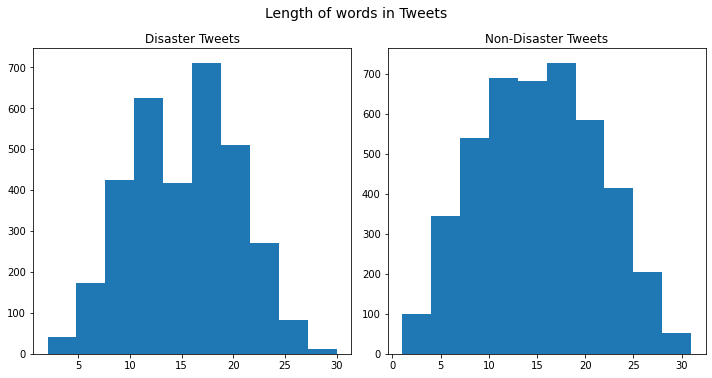

In [7]:
word_len_dis = train_data[train_data['target']==1]['text'].str.split().map(lambda x : len(x))

word_len_non_dis = train_data[train_data['target']==0]['text'].str.split().map(lambda x : len(x))

data = []
data.append(word_len_dis)
data.append(word_len_non_dis)

tPlot, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(10,5))
axes = np.array(axes)

i=0
titles = ["Disaster Tweets", "Non-Disaster Tweets"]
for ax in axes.reshape(-1):
    ax.title.set_text(titles[i])
    ax.hist(data[i])
    i += 1
    
title="Length of words in Tweets"
tPlot.text(0.5, 1.01, title, ha='center', fontsize = 14)
plt.tight_layout()

Quite normalized unimodal distribution with a peak of 20 words. 

In [8]:
def avgwordlen(strlist):
    sum=[]
    for i in strlist:
        sum.append(len(i))
    return sum

avgword_len_dis = train_data[train_data['target']==1]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

avgword_len_non_dis = train_data[train_data['target']==0]['text'].str.split().apply(avgwordlen).map(lambda x: np.mean(x))

group_labels = ['Disaster', 'Non-Disaster']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

fig = ff.create_distplot([avgword_len_dis, avgword_len_non_dis], group_labels, bin_size=.2, colors=colors,)

fig.update_layout(title_text="Average word length in tweets",title_x=0.5,xaxis_title="Text",yaxis_title="Density").show()


Disaster tweets number of words is slightly higher than for non disaster tweets, which suggests that contents is richer for details compared to standard comm that is generally short and quick.

In [10]:
def create_corpus(target):
    corpus = []
    for i in train_data[train_data['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

In [14]:
from string import punctuation
values_list = []
def analyze_punctuations(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        if word in punctuation:
            dic[word] += 1 
    x_items, y_values = zip(*dic.items())
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
fig.add_trace(
      go.Bar(x=values_list[0],y=values_list[1],
             marker=dict(color= 'rgba(196, 94, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[2],y=values_list[3],
             marker=dict(color= 'rgba(255, 163, 102,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show()

More punctuation is used for disaster tweets which suggests people reinforce the text to show panic or seriousness of the situation.

#### Main words in both tweets categories

In [17]:
def wordcloud(data,title):
    words = ' '.join(data['text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()
    
data_disaster = train_data[train_data['target'] == 1]
data_non_disaster = train_data[train_data['target'] == 0]

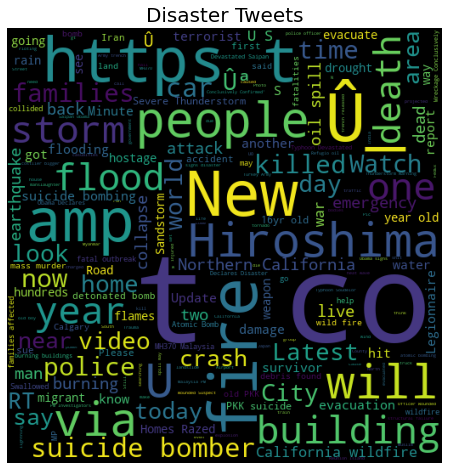

In [20]:
wordcloud(data_disaster,"Disaster Tweets")

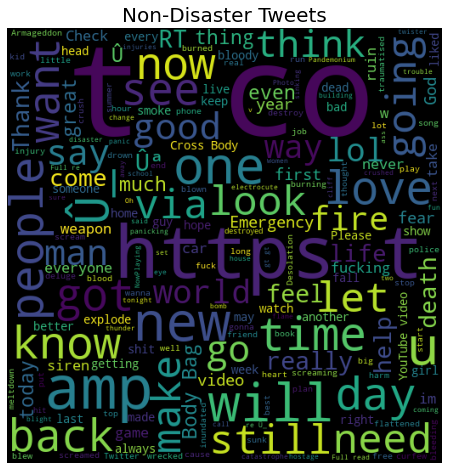

In [21]:
wordcloud(data_non_disaster,"Non-Disaster Tweets")

Both wordclouds are explicite !

### Cleaning
In the perspective of using BERT we don't want to preprocess and clean the dataset too much as we want to stress the model to see how it manages natural language as of. Particularity of BERT is to work on the context understanding so classical cleaning should not be applied.

This is why we only drop keyword and location columns as it is not used in the scope of this project, and remove useless punctuation/emoji and url links, but nothing more on the text column.

In [ ]:
train_data = train_data.drop(['keyword','location'], axis = 1)
test_data = test_data.drop(['keyword','location'], axis = 1)

In [ ]:
train_data.head()

We need to remove superfluous data like url, emoji, ...

In [ ]:
def cleanTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+','',txt)
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    txt = re.sub(r'\n','',txt)
    # to remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    txt = re.sub(r"<.*?>","",txt)
    return txt  

def make_Lower(text):
    return str.lower(text)

In [ ]:
train_data.text = train_data.text.apply(cleanTweet)
train_data.text = train_data.text.apply(make_Lower)

test_data.text = test_data.text.apply(cleanTweet)
test_data.text = test_data.text.apply(make_Lower)

We save these preprocessed datasets as they will be model input from disk resources

In [ ]:
train_data.to_csv('train_preprocessed.csv', index=False) 
test_data.to_csv('test_preprocessed.csv', index=False) 

# Model
### Define main paths

In [ ]:
DATA_PATH = Path('data/')
LABEL_PATH = Path('data/')
MODEL_PATH=Path('models/')
LOG_PATH=Path('logs/')
MODEL_PATH.mkdir(exist_ok=True)
DATA_PATH.mkdir(exist_ok=True)
LOG_PATH.mkdir(exist_ok=True)

### Prepare train and validation sets

In [ ]:
val_set = train_data.sample(frac=0.2, replace=False, random_state=42)
train_set = train_data.drop(index = val_set.index)
print('Number of tweets in val_set:',len(val_set))
print('Number of tweets in train_set:', len(train_set))
val_set.to_csv(str(DATA_PATH) + '/val_set.csv')
train_set.to_csv(str(DATA_PATH) + '/train_set.csv')

In [ ]:
labels = train_data.columns[2:].to_list()
with open(str(LABEL_PATH) + '/labels.txt', 'w') as f:
    for i in labels:
        f.write(i + "\n")
with open(str(LABEL_PATH) + '/labels.csv', 'w') as f:
    for i in labels:
        f.write(i + "\n")        

In [ ]:
all_texts = train_data['text'].to_list()
print('Number of tweets:', len(all_texts))

## Phase 1 - Fine-tune the model
### Create LMDataBunch

In this phase we first fine tune BERT model to our corpus.

We first need to instanciate data bunches for batching learning phase.

Note here we use 'bert-base-uncased' tokenizer defined on pretrained BERT model. 

In [ ]:
print('Create LM databunch object')
t0 = time()
databunch_lm = BertLMDataBunch.from_raw_corpus(
                    data_dir=Path(DATA_PATH),
                    text_list=all_texts,
                    tokenizer='bert-base-uncased',
                    batch_size_per_gpu=16,
                    max_seq_length=512,
                    multi_gpu=False,
                    model_type='bert',
                    logger=logger)
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')


### Create LMLearner
We instanciate a learner for fine tuning the model based on pretrained bert model.

Here we choose simple 'bert' model, and accuracy as metric of learning process.

In [ ]:
print('Create LM learner object')
t0 = time()
metrics = []
metrics.append({'name': 'accuracy', 'function': accuracy})
lm_learner = BertLMLearner.from_pretrained_model(
                            dataBunch=databunch_lm,
                            pretrained_path='bert-base-uncased',
                            output_dir=Path(MODEL_PATH),
                            metrics=metrics,
                            device=device_cuda,
                            logger=logger,
                            multi_gpu=False,
                            logging_steps=50,
                            fp16_opt_level="O2")
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

### Fitting the learner
We fit the LM model with 15 epochs which should be enough to get good understanding of the context considering the dataset.

We choose AdamW with warmup_cosine that variates learning rate from its original value to 0 with cosine periodicity.

In [ ]:
print('Fit LM learner object')

lm_learner.fit(epochs=15,
            lr=1e-4,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="adamw")

In [ ]:
print('Validate LM learner object')
t0 = time()
lm_learner.validate()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
print('Save LM learner object')
t0 = time()
lm_learner.save_model()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

## Phase 2 - Train fine-tuned model for our downstream classification objective
### Create databunch for our classification

In [ ]:
labels_col = ['target']

In [ ]:
print('Create databunch object')
t0 = time()
databunch = BertDataBunch(Path(DATA_PATH), Path(LABEL_PATH),
                          tokenizer='bert-base-uncased',
                          train_file='train_set.csv',
                          val_file='val_set.csv',
                          label_file='labels.txt',
                          text_col='text',
                          label_col=labels_col,
                          batch_size_per_gpu=16,
                          max_seq_length=512,
                          multi_gpu=False,
                          multi_label=True,
                          model_type='bert')
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

### Create Learner for classification
Prepare metrics output with accuracy

In [ ]:
metrics = []
metrics.append({'name': 'accuracy', 'function': accuracy})

Model learning metrics are saved under a tensorboard format in a dedicated folder.

We create this tensorboard out dir as it is not created straightly by the function.

In [ ]:
OUTPUT_DIR = Path(str(MODEL_PATH) + '/finetuned_model')
WGTS_PATH = Path(str(MODEL_PATH) + '/model_out/pytorch_model.bin')
FINETUNED_MODEL_PATH=Path('models/finetuned_model')
FINETUNED_MODEL_PATH.mkdir(exist_ok=True)
FINETUNED_MODEL_TENSORBOARD_PATH = Path(str(MODEL_PATH) + '/finetuned_model/tensorboard')
OUTPUT_DIR.mkdir(exist_ok=True)
FINETUNED_MODEL_TENSORBOARD_PATH.mkdir(exist_ok=True)

In [ ]:
print('Create learner object')
t0 = time()
cl_learner = BertLearner.from_pretrained_model(
                        databunch,
                        pretrained_path=str(MODEL_PATH) + '/model_out',
                        metrics=metrics,
                        device=device_cuda,
                        logger=logger,
                        output_dir=Path(OUTPUT_DIR),
                        finetuned_wgts_path=Path(WGTS_PATH),
                        warmup_steps=50,
                        multi_gpu=False,
                        multi_label=True,
                        is_fp16=True,
                        logging_steps=50)
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

### Define the optimal learning rate
Based on integrated Bert Adam optimizer we try to fit the model with the most suitable learning rate for our fine-tuning. 

This step is important as it is fine tuning on the classification objective, we don't want to retrain the whole model but be as accurate as possible.

We then choose very low lr which constrains the learning process to be slow but accurate.

In [ ]:
print('Fit classification learner object')
t0 = time()
cl_learner.fit(epochs=15,
            lr=9e-5,
            validate=True,
            schedule_type="warmup_cosine",
            optimizer_type="adamw")
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
print('Validate classification learner object')
t0 = time()
cl_learner.validate()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

In [ ]:
print('Save classification learner object')
t0 = time()
cl_learner.save_model()
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')

If you want to get your model accuracy from the metrics you defined, you can download the tensorboard folder and use tensorboard --logdir <myfolder> which will run a localhost entrypoint to the board

## Predictions

In [ ]:
predictor = BertClassificationPredictor(
                model_path=str(MODEL_PATH) + '/finetuned_model/model_out',
                label_path=str(LABEL_PATH),
                multi_label=True,
                model_type='bert',
                do_lower_case=False)

### Unit test

In [ ]:
t0 = time()
tweet = test_data['text'][0]
t = predictor.predict(tweet)
t1 = time()
total_time = t1 - t0
print('total time for operation: ' + str(total_time) + 's')
for pred in t:
    print(tweet + ' - ' + str(pred[1]))

### General prediction

In [ ]:
predictions = []
for idx, row in test_data.iterrows():
    t = predictor.predict(row.text)
    for pred in t:
        predictions.append([row.id, round(pred[1])])

df = pd.DataFrame(predictions, columns=['id','target'])        
df.to_csv('Submission.csv', index=False)        